In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from typing import List
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

---

## Read the Data

In [3]:
txns = pd.read_csv('./data/ANZ_clean_transactions.csv')

In [4]:
impute_columns = ['merchant_state', 'merchant_id', 'merchant_long_lat', 'merchant_suburb', 'card_present_flag']
for col in impute_columns:
   txns[col].fillna('N/A', inplace=True)

In [5]:
txns.isna().sum()

Unnamed: 0           0
status               0
card_present_flag    0
account              0
long_lat             0
txn_description      0
merchant_id          0
first_name           0
balance              0
date                 0
gender               0
age                  0
merchant_suburb      0
merchant_state       0
extraction           0
amount               0
transaction_id       0
customer_id          0
merchant_long_lat    0
movement             0
month                0
weekday              0
month_name           0
day_name             0
day_type             0
log_amount           0
dtype: int64

---

### What's the annual salary for each cusotmers?

Since we only have 3 months of data about each customer's salary, we will need to figure out how frequently a customer is paid and how much money they are paid during each transaction.

Expectation:
- Each customer is paid consistently for 3 months (e.g. weekly/biweekly/monthly)
- Each customer is paid the same amount each time

In [6]:
customers = txns.customer_id.unique()

In [7]:
salary = txns[txns.txn_description == 'PAY/SALARY']

In [8]:
def salary_record(customer_id: str, salary: pd.DataFrame = salary) -> pd.DataFrame:
   """Return a payment history of the customer with <customer_id>.
   """
   customer_payment = salary.loc[salary.customer_id == customer_id, ['date', 'month_name', 'day_name', 'amount']]
   return customer_payment

In [9]:
def good_salary_payment(customer_id: str, salary: pd.DataFrame = salary) -> bool:
   """Check if the customer with <customer_id> is paid consistently from August to 
   October, and if he/she is paid the same amount each time. 

   Return true if the customer satisifies these requirements and false otherwise.
   """
   customer_salary = salary_record(customer_id)
   # see if the customer is paid over 3 months
   if customer_salary['month_name'].nunique() < 3:
      return False
   # See if the customer is paid the same amount each time
   if customer_salary['amount'].nunique() != 1:
      return False
   # prepare the data for calculating interval differences
   customer_salary['date_difference'] = pd.to_datetime(customer_salary.date) - pd.to_datetime(customer_salary.date.shift(1))
   # See if the customer is paid regularly 
   if customer_salary['date_difference'].nunique() != 1:
      return False

   return True

In [10]:
irregular_customers = []
for customer in customers:
   if not good_salary_payment(customer):
      irregular_customers.append(customer)

In [11]:
len(irregular_customers)

19

There are 19 customers who either weren't paid regularly for 3 months or weren't paid the same amount each time

In [12]:
irregular_customers

['CUS-860700529',
 'CUS-2630892467',
 'CUS-2376382098',
 'CUS-51506836',
 'CUS-2178051368',
 'CUS-1646183815',
 'CUS-2283904812',
 'CUS-1604596597',
 'CUS-2599279756',
 'CUS-3462882033',
 'CUS-423725039',
 'CUS-3201519139',
 'CUS-1739931018',
 'CUS-1233833708',
 'CUS-1816693151',
 'CUS-2110742437',
 'CUS-497688347',
 'CUS-880898248',
 'CUS-72755508']

In [13]:
irregular_customers_paid_with_different_amounts = []
for irregular_customer in irregular_customers:
   if salary_record(irregular_customer).amount.nunique() != 1:
      irregular_customers_paid_with_different_amounts.append(irregular_customer)

In [14]:
len(irregular_customers_paid_with_different_amounts)

0

It turns out that among these irregular customers, some were paid for only 2 of the 3 months or were paid in different periods (e.g. paid monthly during August and paid weekly on September and October) over the 3 months. Some have their salary payment posted more than once on the same day.

### Plan:
- Assume that a customer should be paid a set amuont constantly every shortest period observed (i.e. if you are observed being paid 100 weekly on August but then paid 100 biweekly on September and October, then asssume that you should have been paid 100 weekly from August to October)
- Find the shortest period at which each customer is paid throughout the 3 months (ignore multiple payments posted on the same day)
- Scale the amount down to its daily equivalent (i.e. if the shortest period is biweekly, then divide your biweekly amount by 14 to get the daily amount)
- Multiply that scaled daily amount by 365.25 to get an estimate of the annual salary

In [15]:
def get_annual_salary(customer_id: str, salary: pd.DataFrame = salary) -> float:
   """Return the estimate of the annual salary of customer with <customer_id>.
   """
   customer_salary = salary_record(customer_id)
   payment_period = (pd.to_datetime(customer_salary.date) - pd.to_datetime(customer_salary.date.shift(1))).map(lambda date: date.days)
   payment_freq = payment_period[payment_period > 0].min()
   annual_salary = customer_salary.amount.unique()[0] / payment_freq * 365.25
   
   return np.round(annual_salary, 4)

In [16]:
annual_salary = pd.DataFrame({
   'customer_id': customers,
   'annual_salary': [get_annual_salary(customer) for customer in customers]
})

In [17]:
annual_salary.sort_values('annual_salary', ascending=False).head()

,customer_id,annual_salary
9,CUS-3142625864,135038.6646
91,CUS-2738291516,132781.9414
74,CUS-2155701614,127484.7729
6,CUS-2031327464,118985.9271
99,CUS-261674136,114931.1304


### How's Customers' Annual Salary Distributed?

In [18]:
annual_salary.annual_salary.describe()

count       100.000000
mean      66367.021692
std       24827.677005
min       29405.020100
25%       47998.806975
50%       59861.735600
75%       81895.637525
max      135038.664600
Name: annual_salary, dtype: float64

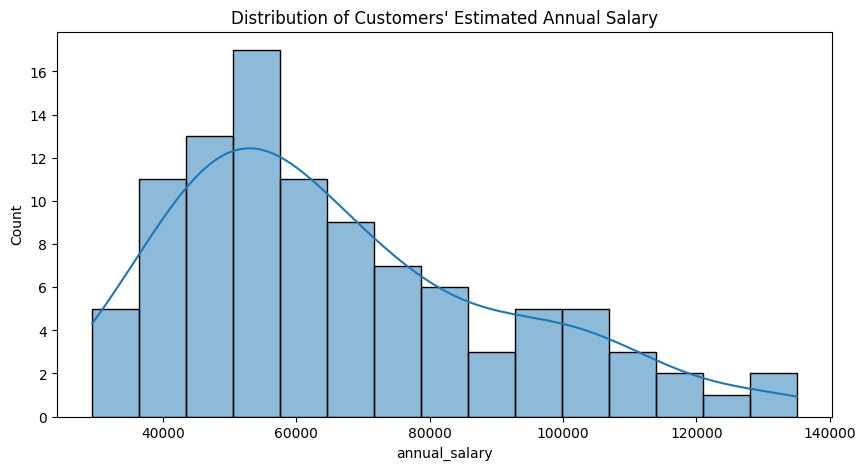

In [19]:
plt.figure(figsize=(10,5));
sns.histplot(data=annual_salary, x='annual_salary', kde=True, bins=15);
plt.title('Distribution of Customers\' Estimated Annual Salary');

---

## What's the correlation between customers' annual salary and some features?

### Salary-Informed Features Engineering

In [20]:
txns.columns

Index(['Unnamed: 0', 'status', 'card_present_flag', 'account', 'long_lat',
       'txn_description', 'merchant_id', 'first_name', 'balance', 'date',
       'gender', 'age', 'merchant_suburb', 'merchant_state', 'extraction',
       'amount', 'transaction_id', 'customer_id', 'merchant_long_lat',
       'movement', 'month', 'weekday', 'month_name', 'day_name', 'day_type',
       'log_amount'],
      dtype='object')

Some features that may have important indication of a customer's annual salary can be:
- Gender
- Age
- State
- Purchase longitude
- Purchase latitude 
- Average merchant longitude
- Average merchant latitude
- Average number of transactions made per month
- Average amount spended per month
- median balance over 3 months

In [21]:
from statistics import mode

In [22]:
def non_na_mode(x: pd.Series):
   return mode(x[x != 'N/A'])

In [23]:
if 'long' not in txns.columns:
   txns['long'] = txns.long_lat.map(lambda x: float(x.split(' ')[0]))
if 'lat' not in txns.columns:
   txns['lat'] = txns.long_lat.map(lambda x: float(x.split(' ')[1]))
if 'merchant_long' not in txns.columns:
   txns['merchant_long'] = txns.merchant_long_lat.map(lambda x: float(x.split(' ')[0]) if x != 'N/A' else x)
if 'merchant_lat' not in txns.columns:
   txns['merchant_lat'] = txns.merchant_long_lat.map(lambda x: float(x.split(' ')[1]) if x != 'N/A' else x)

In [24]:
customers_group = txns.groupby(['customer_id', 'gender', 'age', 'long', 'lat'], as_index=False)

In [25]:
customers_group = customers_group.agg({
   'merchant_state': non_na_mode,
   'merchant_long':non_na_mode,
   'merchant_lat': non_na_mode
})

In [26]:
avg_txns_month = pd.DataFrame(txns.groupby(['customer_id', 'month'], as_index=False).size()).groupby('customer_id', as_index=False)['size'].apply(lambda x: np.floor(x.mean()))
avg_txns_month.columns = ['customer_id', 'avg_txns_per_month']

In [27]:
avg_amount_month = pd.DataFrame(txns.groupby(['customer_id', 'month'], as_index=False).amount.sum()).groupby('customer_id', as_index=False)['amount'].apply(lambda x: np.round(x.mean(), 2))
avg_amount_month.columns = ['customer_id', 'avg_amount_per_month']

In [28]:
median_balance = txns.groupby('customer_id', as_index=False).balance.median()
median_balance.columns = ['customer_id', 'median_balance']

Join all the features together to form the feature set

In [29]:
from functools import reduce

dfs = [customers_group, avg_txns_month, avg_amount_month, median_balance]
customer_features = reduce(lambda df1, df2: pd.merge(df1, df2, on='customer_id'), dfs)

### Datasets Summary

- Features: `customer_feaures`
- Response: `annual_salary`

In [30]:
customer_features.head()

,customer_id,gender,age,long,lat,merchant_state,merchant_long,merchant_lat,avg_txns_per_month,avg_amount_per_month,median_balance
0,CUS-1005756958,F,53,153.03,-27.51,QLD,153.03,-27.45,24.0,5422.99,1204.40
1,CUS-1117979751,M,21,115.81,-31.82,WA,115.86,-31.95,33.0,11328.12,8838.41
2,CUS-1140341822,M,28,144.97,-37.42,VIC,144.96,-37.81,26.0,5670.20,6358.35
3,CUS-1147642491,F,34,151.04,-33.77,NSW,151.21,-33.87,39.0,9660.27,8473.43
4,CUS-1196156254,F,34,138.52,-35.01,SA,138.60,-35.02,81.0,12016.91,22312.76


In [31]:
annual_salary.head()

,customer_id,annual_salary
0,CUS-2487424745,52891.8525
1,CUS-2142601169,52289.7118
2,CUS-1614226872,46547.9818
3,CUS-2688605418,60534.9696
4,CUS-4123612273,55728.8014


In [44]:
customer_features.isna().sum()

customer_id             0
gender                  0
age                     0
long                    0
lat                     0
merchant_state          0
merchant_long           0
merchant_lat            0
avg_txns_per_month      0
avg_amount_per_month    0
median_balance          0
dtype: int64

### Correlation of Features with Annual Salary

In [32]:
customers_salary = pd.merge(customer_features, annual_salary, on='customer_id')

In [112]:
salary_cat_cols = ['gender', 'merchant_state']
salary_location_cols = ['long', 'lat', 'merchant_long', 'merchant_lat']
salary_num_cols = salary_location_cols + ['age', 'avg_txns_per_month', 'avg_amount_per_month', 'median_balance', 'annual_salary']
non_location_cols = salary_cat_cols + salary_num_cols[len(salary_location_cols):]

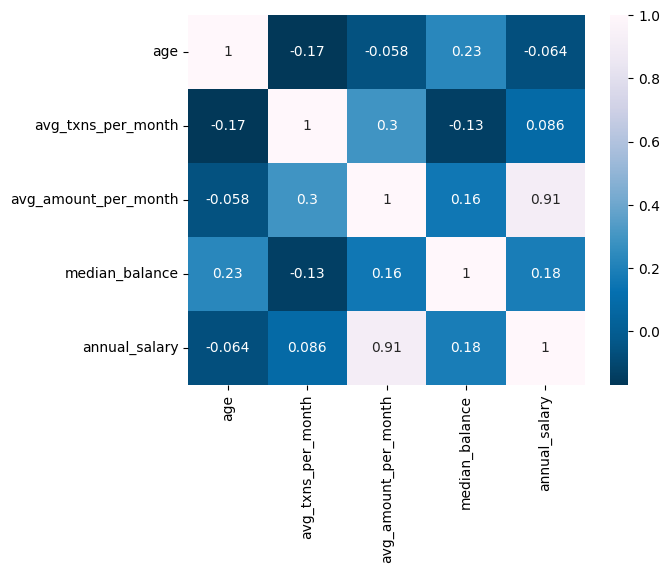

In [80]:
sns.heatmap(customers_salary[non_location_cols].corr(), annot=True, cmap='PuBu_r');

`avg_amount_per_mont` has a very high positive correlation with `annual_salary`

### By Gender

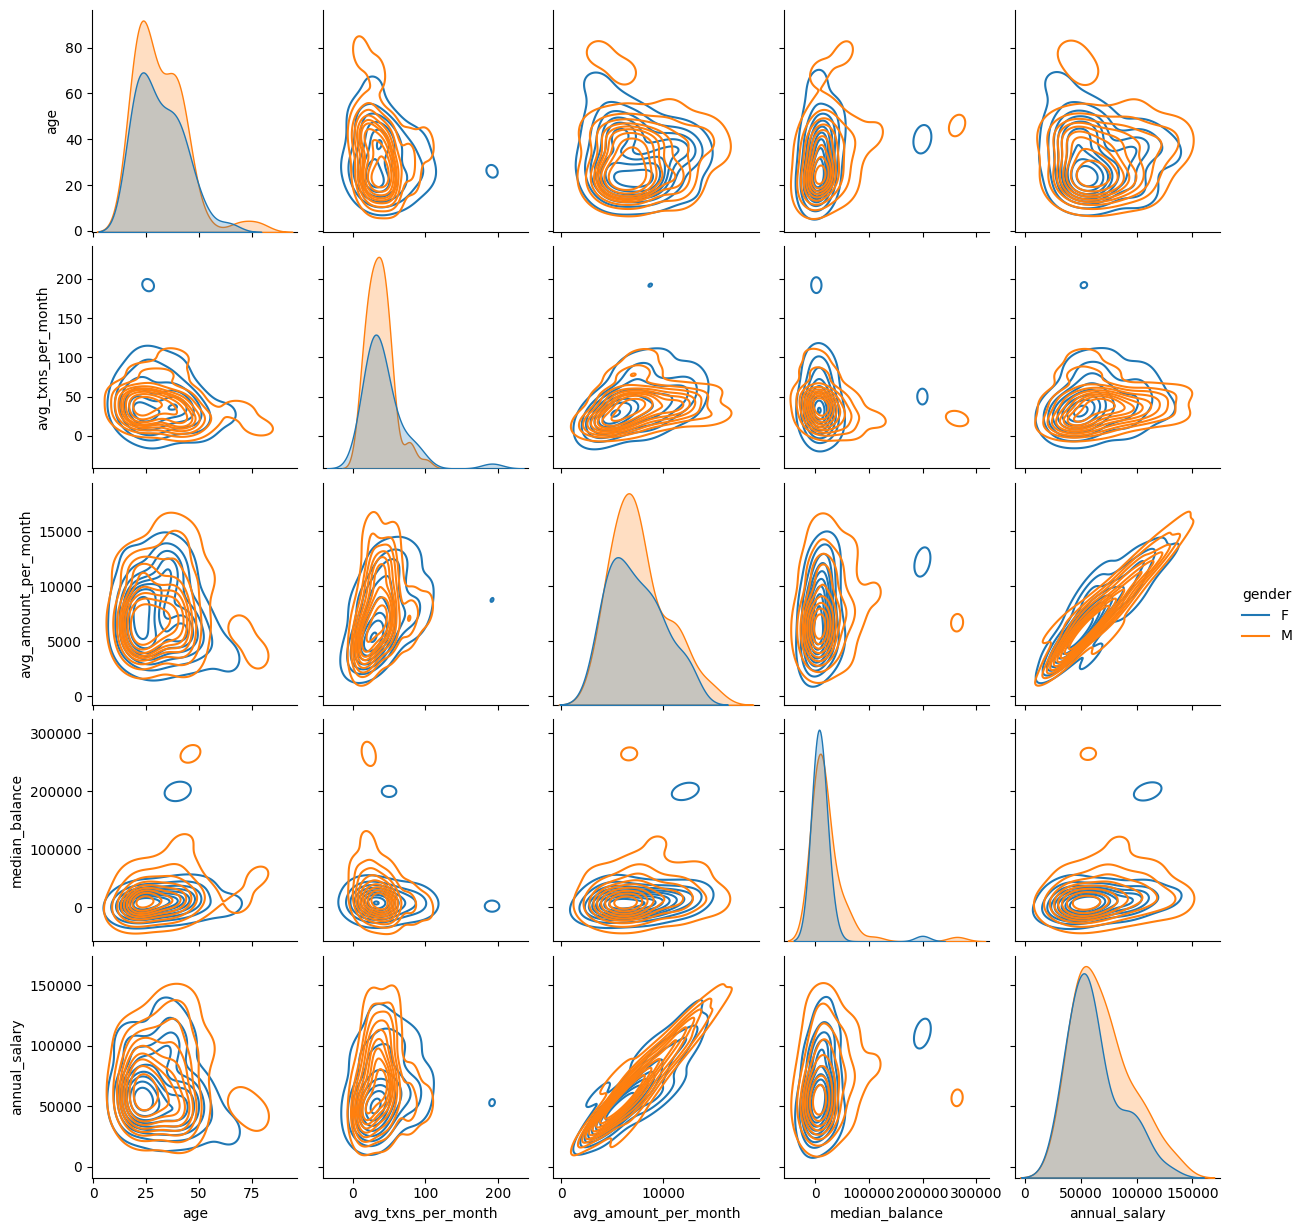

In [81]:
sns.pairplot(data=customers_salary[non_location_cols], kind='kde', hue='gender');

### By Merchant State

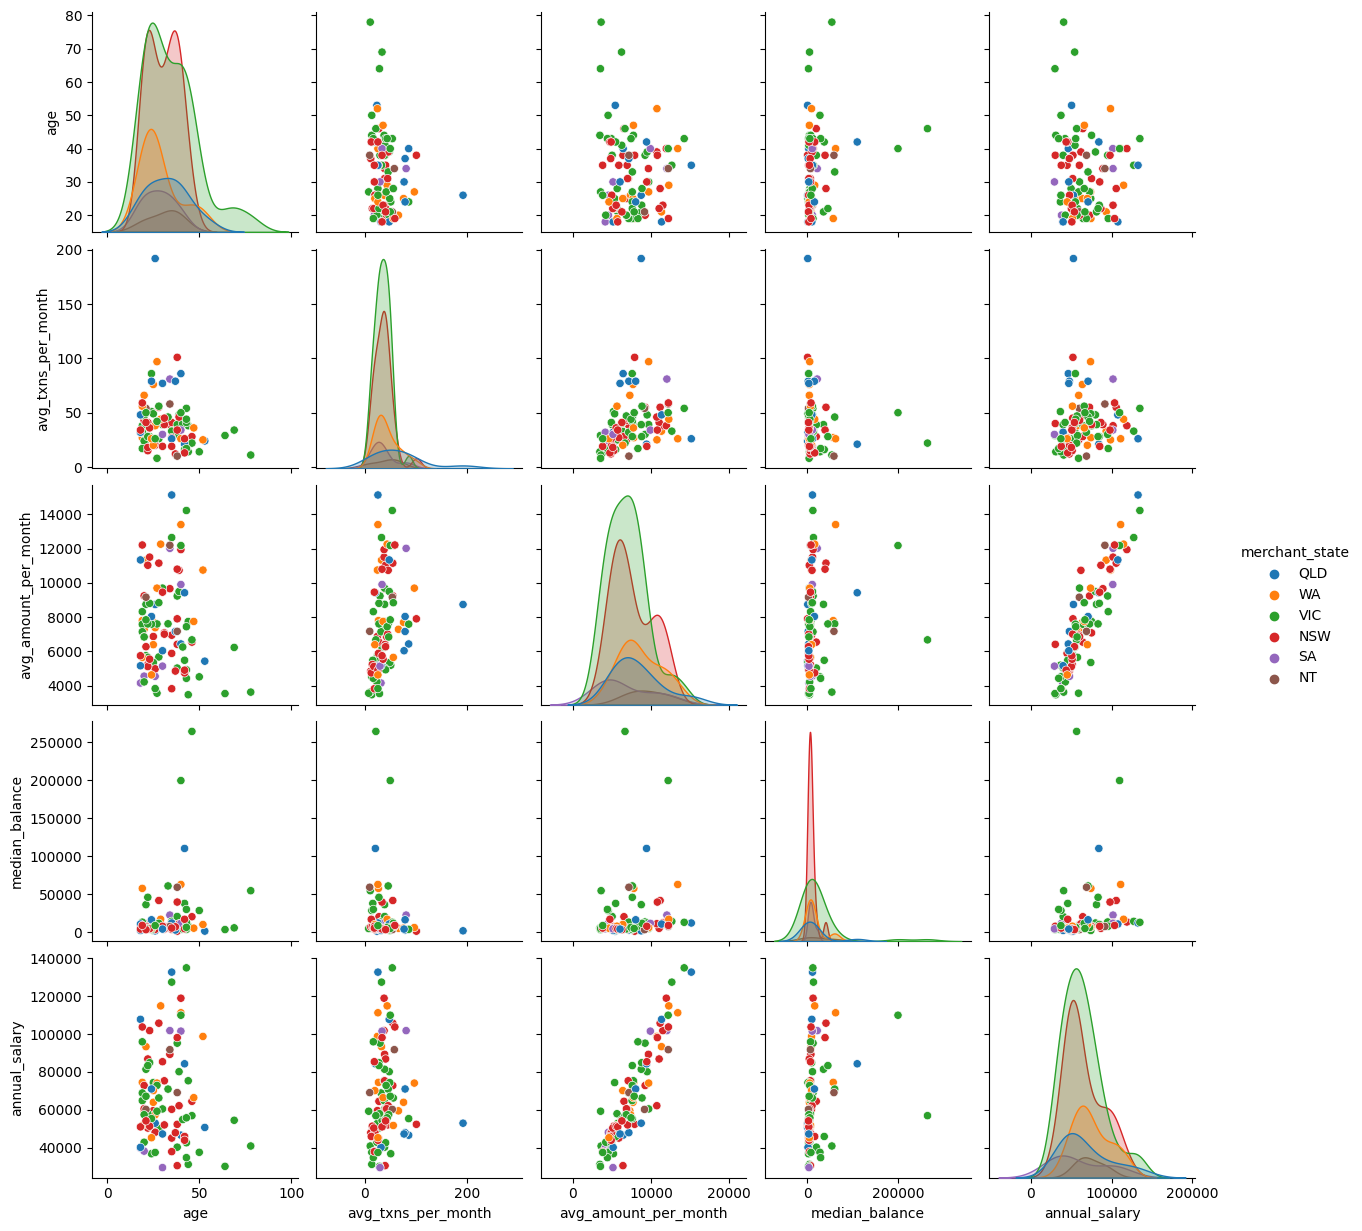

In [82]:
sns.pairplot(data=customers_salary[non_location_cols], hue='merchant_state');

---

# Training Models

### Preprocessing

In [142]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [66]:
features = customers_salary.iloc[:, 1:-1]
response = customers_salary[['annual_salary']]

In [116]:
cols_transformer = make_column_transformer(
   (OneHotEncoder(sparse=False), salary_cat_cols),
   (StandardScaler(), salary_num_cols[:-1])
)

Split the features and response into training and testing sets

In [117]:
train_features, test_features, train_response, test_response = train_test_split(features, response, test_size=0.3, random_state=42)

In [118]:
print(train_features.shape, test_features.shape, train_response.shape, test_response.shape)

(70, 10) (30, 10) (70, 1) (30, 1)


Build a regression model as a baseline to predict a customer's salary using the features identified above

In [122]:
lm = LinearRegression()
lm_pipeline = make_pipeline(cols_transformer, lm)

In [123]:
lm_pipeline.fit(train_features, train_response)
lm_pred = lm_pipeline.predict(test_features)

In [137]:
# Calculate the RMSE of the linear regression prediction
print('RSME: ', np.round(np.sqrt(mean_squared_error(y_true=test_response, y_pred=lm_pred)), 2))

RSME:  10093.46


Build a decision tree model to predict a customer's salary using the features identified above. How does it compare with the baseline?

In [132]:
dt = DecisionTreeRegressor()
dt_pipeline = make_pipeline(cols_transformer, dt)

In [133]:
dt_pipeline.fit(train_features, train_response)
dt_pred = dt_pipeline.predict(test_features)

In [138]:
# Calculate the RMSE of the decision tree prediction
print('RMSE: ', np.round(np.sqrt(mean_squared_error(y_true=test_response, y_pred=dt_pred)), 2))

RMSE:  11108.52


Turns out the decision tree model performs worse than does the linear regression model

---

The linear regression and decision tree models both perform poorly given that they have such a high RMSE in predictions. Using either to segment customers into income group for marketing purposes isn't a good idea and will most likely result in error-prone classification. 

A total of 100 customers is not enough for a sample size to train models on. Additionally, some features generated to predict annual salary may not be of much importance as shown in the correlation plot above. This could also be a reason why both models perform poorly, and perhaps a dimensionality reduction or feature selection technique can be applied to improve the model performances. However, we are not going deep in that direction given the constraint of this project.